In [ ]:
%matplotlib inline


# A demo of K-Means clustering on the handwritten digits data


In this example we compare the various initialization strategies for
K-means in terms of runtime and quality of the results.

As the ground truth is known here, we also apply different cluster
quality metrics to judge the goodness of fit of the cluster labels to the
ground truth.

Cluster quality metrics evaluated (see `clustering_evaluation` for
definitions and discussions of the metrics):

=========== ========================================================
Shorthand    full name
=========== ========================================================
homo         homogeneity score
compl        completeness score
v-meas       V measure
ARI          adjusted Rand index
AMI          adjusted mutual information
silhouette   silhouette coefficient
=========== ========================================================




In [50]:
print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(7)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

Automatically created module for IPython interactive environment


In [64]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    if isinstance(estimator,GaussianMixture):
        estimator.labels_ = estimator.predict(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_ if hasattr(estimator, 'inertia_') else 0,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_,
                                                average_method='arithmetic'),
             metrics.normalized_mutual_info_score(labels,  estimator.labels_,
                                                average_method='arithmetic'),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [71]:
print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(90 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tNMI\tsilhouette')

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)
bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)
# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
# PCA降维之后再做KMEANs
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

bench_k_means(AffinityPropagation(),name="A.P.", data=data)

bandwidth = estimate_bandwidth(data, quantile=0.1)
bench_k_means(MeanShift(bandwidth=bandwidth, bin_seeding=True),name="MeanShift",data=data)

bench_k_means(AgglomerativeClustering(n_clusters=10, linkage='ward'),name="W.H.C.",data=data)

bench_k_means(AgglomerativeClustering(),name="A.C.",data=data)

bench_k_means(DBSCAN(),name="DBSCAN",data=data)

bench_k_means(GaussianMixture(n_components=n_digits),name="GMM",data=data)

bench_k_means(SpectralClustering(),name="SC",data=data)

print(90 * '_')

n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	NMI	silhouette
k-means++	0.29s	69478	0.613	0.661	0.636	0.483	0.632	0.636	0.126
random   	0.20s	69432	0.601	0.649	0.624	0.465	0.620	0.624	0.155
PCA-based	0.04s	70768	0.668	0.695	0.681	0.558	0.678	0.681	0.138
random   	0.20s	69664	0.681	0.721	0.700	0.573	0.697	0.700	0.167
GMM      	0.48s	0	0.552	0.629	0.588	0.371	0.584	0.588	0.098


/Users/liks/opt/miniconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 

In [66]:
# THE CODE BELOW IS VISUALIZATION
# #############################################################################
# Visualize the results on PCA-reduced data
reduced_data = PCA(n_components=2).fit_transform(data)
# kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
# kmeans.fit(reduced_data)
gmm = GaussianMixture(n_components=n_digits)
gmm.fit(reduced_data)
gmm.labels_ = gmm.predict(reduced_data)

In [67]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

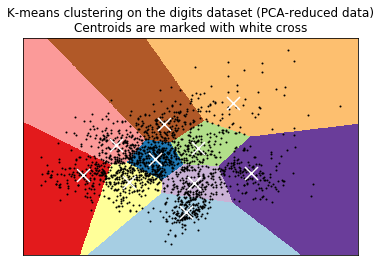

In [68]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

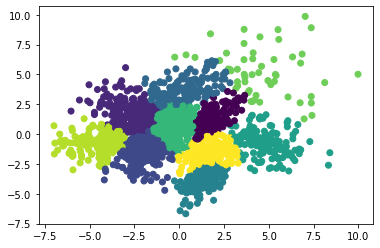

In [69]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1],c=gmm.labels_)

In [40]:
from sklearn.cluster import AffinityPropagation

In [41]:
af = AffinityPropagation().fit(reduced_data)
result = af.labels_

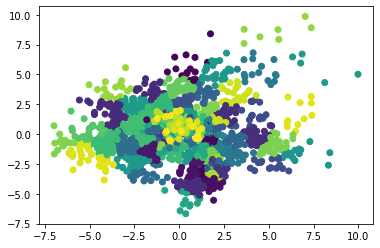

In [42]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1],c=result)

In [45]:
from sklearn.cluster import DBSCAN

In [48]:
DS = DBSCAN().fit(data)

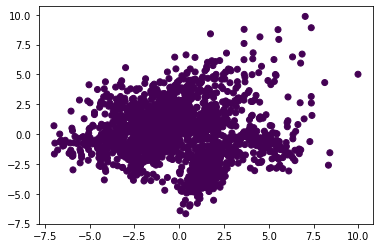

In [49]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1],c=DS.labels_)